In [68]:
## Loading / clustering data functions
import pandas as pd
import Bio.Phylo as bp

class TrueTree:
    def __init__():
        self.true_tree = bp.read('')


class CNVData:
    def __init__(self):
        self.CNVData = []
        self.label_replace_dictionary = {
        'SM1_centroids_nucleotides': 'Chelydra_serpentina',
        'SM2_centroids_nucleotides': 'Anolis_sagrei',
        'SM3_centroids_nucleotides': 'Elgaria_multicarinata',
        'SM4_centroids_nucleotides': 'Lamprophis',
        'SM5_centroids_nucleotides': 'Agkistrodon_piscivorus',
        'SM6_centroids_nucleotides': 'Xenopeltis_unicolor',
        'SM7_centroids_nucleotides': 'Alligator_mississippiensis',
        'SM8_centroids_nucleotides': 'Sceloporus_undulatus',
        'SM9_centroids_nucleotides': 'Pogona',
        'SM10_centroids_nucleotides': 'Sternotherus_odoratus',
        'SM11_centroids_nucleotides': 'Sternotherus_odoratus',
        'SM12_centroids_nucleotides': 'Scincella_lateralis',
        'SM13_centroids_nucleotides': 'Terrapene_carolina',
        'SM14_centroids_nucleotides': 'Agkistrodon_piscivorus',
        'SM15_centroids_nucleotides': 'Eublepharis_macularius',
        'TC_centroids_nucleotides': 'Thamnophis_sirtalis',
        'HS08_centroids_nucleotides': 'Thamnophis_elegans',
        'HS11_centroids_nucleotides': 'Thamnophis_couchii'
        }

    
    def readCNVMatrix(self,file_path):
        ## Read in data-file using Pandas. Assume TSV. Use column 1 as index. 
        ## Transpose so genes are columns. 
        self.CNVData = pd.read_csv(file_path,sep='\t', index_col=0).transpose()
        
        ## Drop unneccesary Column counting total CNV per species
        self.CNVData = self.CNVData.drop(['Total'])
        
        ## Min/max scaling of copy number
        self.CNVData = (self.CNVData - self.CNVData.min()) / (self.CNVData.max()-self.CNVData.min()) ## Min-max transform
        
        ## Replace NaN entries --> 0
        self.CNVData.fillna(0,inplace=True) 
        
        ## Relabel species names to line up with 'true' tree
        self.CNVData.index = self.relabelIndex(self.CNVData.index)
        
        return(self.CNVData)
    
    def relabelIndex(self,labels):
       # correct names 
        fixed_labels = []

        for label in labels:
            if label in self.label_replace_dictionary:
                fixed_labels.append(self.label_replace_dictionary[label])
            else:
                fixed_labels.append(label)
        return(fixed_labels)


In [12]:
dm = CNVData().readCNVMatrix('FundamentalsProgramming/LS_blastn_Gar_noDenom.txt')


NameError: name 'sk' is not defined

In [26]:
import inspect
import scipy as sc
import matplotlib.pyplot as plt

In [19]:
k =sklearn.cluster.AgglomerativeClustering(n_clusters=4,compute_full_tree=True).fit(dm)
k = sc.cluster.hierarchy.linkage(dm)

In [41]:
tree = sc.cluster.hierarchy.to_tree(k)

In [34]:
type(tree.get_left())

scipy.cluster.hierarchy.ClusterNode

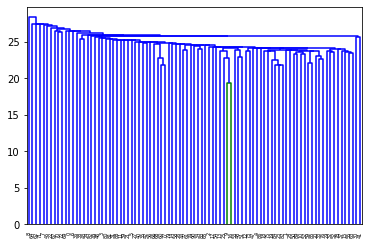

In [45]:
tree = sc.cluster.hierarchy.dendrogram(k)

dict_keys(['icoord', 'dcoord', 'ivl', 'leaves', 'color_list'])

In [125]:
import Bio.Phylo as bp
true_tree = 'FundamentalsProgramming/trueTree.phy'

In [135]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 20]

In [136]:
root = bp.read(true_tree,'newick')

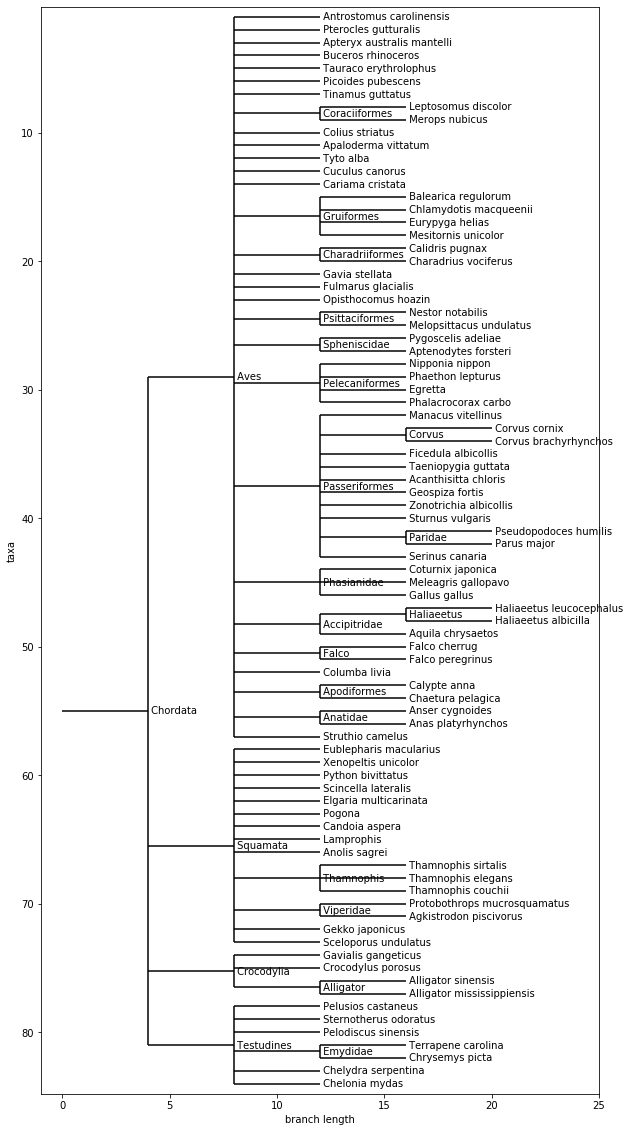

In [137]:
#fig = plt.figure(figsize=(4,4))
#fig.set_size_inches(18.5, 10.5)
bp.draw(newick)

        
    
#fig.savefig('/Users/student/storage/fundamentals/programming/data/test_newick_out.png')

In [93]:
dir()

NoneType

In [47]:
def Cluster: ## cluster class, can execute the clustering algo on the thing, store the result. (into a tree class?)
    ## clustering class that has methosd
    def __init__(): ## takes a CNVData matrix. 
        self.clustering_result = []
        self.tree = []
        self.available_methods = ['Ward','Complete','Single','Average']
        self.clustering_range = np.arange(3,10)
    
    def cluster(self,data,method=None,num_clusters=None):
        ## try to load the method. 
        if method:
            try:
                self.available_methods.index(method)
            except ValueError:
                raise Exception('Selected clustering method not available.')
        else:
            method = 'Ward'
            
            
        ## determine appropriate # of clusters unless speciied
        if num_clusters:
            self.try_cluster(data,alg,num_clusters)
        else:
            
    
    def agglomerativeClustering(self,linkage,data,n_clusters):
        
        self.cluster_result = sklearn.cluster.AgglomerativeClustering(n_clusters=n_clusters, linkage = linkage).fit_predict(data)
        sk
        
        
    
    def ward(self,data,n_clusters):
        return(sklearn.cluster.AgglomerativeClustering(n_clusters=n_clusters,linkage='ward').fit(matrix))

    def complete(self,data,n_clusters):
        return(sklearn.cluster.AgglomerativeClustering(n_clusters=n_clusters, linkage='complete').fit(matrix))

    def single(self,data,n_clusters):
        return(sklearn.cluster.AgglomerativeClustering(n_clusters=n_clusters, linkage='single').fit(matrix))

    def average(self,data,n_clusters):
        return(ssklearn.cluster.AgglomerativeClustering(n_clusters=n_clusters, linkage='average').fit(matrix))

    
    

SyntaxError: invalid syntax (<ipython-input-47-7ad640ca684a>, line 1)